In [1]:
import os
import json

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
dataset_name = 'prepared_facebook_data'
folder_name = 'facebook_comm_vol'
first_test_path= '../other_data_experiments/{}/first experiment/'.format(folder_name)
second_test_path= '../other_data_experiments/{}/second experiment/'.format(folder_name)
GRAPHS_DIR = '../other_data_experiments/{}/graphs/'.format(folder_name)

In [4]:
grid_file = first_test_path+"res_grid_search_{}.csv".format(dataset_name)
random_search_files = [first_test_path+"res_rand_{}_{}.csv".format(dataset_name, i) 
                       for i in range(1,11)]
first_group_files = [first_test_path+"res_rand_groups_{}_{}.csv".format(dataset_name, i) 
                       for i in range(1,11)]

In [5]:
grid_df = pd.read_csv(grid_file, usecols = ['experiment_name',
                                           'mean_test_score',
                                           'params'])
grid_df['run_number']=1
grid_df['iter_num'] = range(1, grid_df.shape[0]+1)    

default_df = pd.read_csv(first_test_path+\
                         "res_default_{}.csv".format(dataset_name), 
                         usecols = ['experiment_name',
                                    'mean_test_score',
                                    'params'])
default_df['run_number']=1
default_df['iter_num'] = range(1, default_df.shape[0]+1)    
    
random_df = pd.DataFrame([])
for file_name in random_search_files:
    file_df = pd.read_csv(file_name, 
                          usecols = ['experiment_name', 'mean_test_score',
                                     'params','run_number'])
    file_df['iter_num'] = range(1, file_df.shape[0]+1) 
    random_df = pd.concat([random_df, file_df], sort = False)

In [6]:
iters_info = {}
scores_info = {}

### set stop criterion

In [62]:


stop_iter_num = 10



In [63]:
sec_and_third_group_files = [second_test_path+\
                             "GR_S_2_and_3_groups_with_{}_{}_{}.csv".format(
    stop_iter_num, i, dataset_name)
                             for i in range(1,11)]

In [64]:
gr_2_and_3_df = pd.DataFrame([])
for file_name in sec_and_third_group_files:
    file_df = pd.read_csv(file_name, 
                              usecols = ['experiment_name', 'mean_test_score',
                                         'params','run_number','iter_num'])
    gr_2_and_3_df = pd.concat([gr_2_and_3_df, file_df], sort = False)

In [65]:
run_iter = gr_2_and_3_df.loc[
    gr_2_and_3_df['experiment_name']=='random search for 3 group'
].groupby('run_number')['iter_num'].max().reset_index()

In [66]:
params = gr_2_and_3_df.loc[
    gr_2_and_3_df['experiment_name']=='random search for 3 group'
].merge(run_iter, 
        left_on=['run_number', 'iter_num'], 
        right_on = ['run_number', 'iter_num'], 
        how = 'inner')

In [67]:
end_of_first_part = gr_2_and_3_df.groupby(by='run_number')['iter_num'].min().to_dict()

In [68]:
first_group_df = pd.DataFrame([])
for file_name in first_group_files:
    file_df = pd.read_csv(file_name, 
                          usecols = ['experiment_name', 'mean_test_score',
                                     'params','run_number'])
    file_df['iter_num'] = range(1, file_df.shape[0]+1) 
    run_num = np.unique(file_df['run_number'])[0]
    file_df = file_df.loc[file_df['iter_num']<end_of_first_part[run_num]]
    first_group_df = pd.concat([first_group_df, file_df], sort = False)

In [69]:
full_df = pd.concat([first_group_df, gr_2_and_3_df], sort = False)

In [70]:
scores = full_df.groupby('run_number')['mean_test_score'].max()
print("MEAN best score:", np.mean(scores))
print("STD best score:", np.std(scores))

MEAN best score: 0.6683499488506007
STD best score: 0.0012250001012563665


In [71]:
iters_num = full_df.groupby(by='run_number')['iter_num'].max()

In [72]:
print("MEAN iters num:", np.mean(iters_num))
print("STD iters num:", np.std(iters_num))

MEAN iters num: 521.8
STD iters num: 124.07239821974912


In [73]:
max_iter = np.max(iters_num)

In [74]:
max_iter

685.0

In [75]:
max_score_and_iter = full_df.groupby(by = 'run_number')['mean_test_score', 'iter_num'].max()

<ipython-input-75-4338ff2a0ca9>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_score_and_iter = full_df.groupby(by = 'run_number')['mean_test_score', 'iter_num'].max()


In [76]:
full_df = full_df.loc[:, ['mean_test_score', 'iter_num', 'run_number']]

In [77]:
# Продление конечной оценки до максимальной итерации 
# для отрисовки конца доверительного интервала

In [78]:
list_for_extension = list(max_score_and_iter.loc[
        max_score_and_iter.iter_num < max_iter].index)

In [79]:
full_df = full_df.dropna(how = 'all')

In [80]:
agg_df_GRS = full_df.groupby('run_number')['iter_num'].max().values

iters_info['GRS_{}'.format(stop_iter_num)] = {
    'mean':np.mean(agg_df_GRS), 
    'std':np.nanstd(agg_df_GRS)
}


In [81]:
for run_number in list_for_extension:
    new_part_df = pd.DataFrame([], columns=full_df.columns)
    new_part_df['iter_num']=range(int(max_score_and_iter.loc[run_number, 'iter_num']+1), 
                                  int(max_iter)+1)
    new_part_df['run_number'] = run_number
    new_part_df['mean_test_score'] = max_score_and_iter.loc[run_number, 
                                                            'mean_test_score']
    full_df = pd.concat([full_df, new_part_df], sort = False)
    
stopped_full_df = pd.DataFrame([])
for run_number in np.unique(full_df.run_number):
    copy_df = full_df.loc[full_df.run_number == run_number].sort_values(by = 'iter_num')
    copy_df['mean_test_score']=copy_df['mean_test_score'].cummax()
    copy_df['run_number']=run_number
    #full_df.loc[full_df.run_number == run_number]=full_df.loc[full_df.run_number == run_number].sort_values(by = 'iter_num')
    #full_df.loc[full_df.run_number == run_number, 'mean_test_score'] = \
    #    full_df.loc[full_df.run_number == run_number, 'mean_test_score'].cummax()
    stopped_full_df = pd.concat([stopped_full_df, copy_df], sort=False)


In [82]:
full_df = stopped_full_df

In [83]:
full_df['experiment_name']='group search'

In [84]:
## RANDOM_SEARCH
#get best scores per itration for each random_search performance:
random_df_stopped=pd.DataFrame([])
max_iters_for_RS = []
for i in random_df.run_number.unique():    
    tmp=pd.DataFrame(random_df.loc[random_df.run_number==i, 
                                   "mean_test_score"].copy().cummax())
    tmp["iter_num"]=random_df.loc[random_df.run_number==i, "iter_num"]
    curr_max=tmp.groupby("mean_test_score").count().reset_index()
    max_score=curr_max.loc[curr_max["iter_num"]>=stop_iter_num, 
                           "mean_test_score"].values[0]
    
    tmp_before=tmp.loc[tmp["mean_test_score"]<max_score] #get steps before stop criterion
    tmp_stop=tmp.loc[tmp["mean_test_score"]==max_score].sort_values(by="iter_num")
    tmp_stop=tmp_stop.iloc[:stop_iter_num]
    df_stopped=pd.concat([tmp_before, tmp_stop], sort = False)  
    df_stopped['run_number']=i
    max_iters_for_RS.append(df_stopped.shape[0])
    random_df_stopped=pd.concat([random_df_stopped, df_stopped], sort=False)
    
    
print("MEAN iters num:", np.mean(max_iters_for_RS))
print("STD iters num:", np.std(max_iters_for_RS))

MEAN iters num: 18.4
STD iters num: 7.323933369440222


In [85]:
np.max(max_iters_for_RS)

37

In [31]:
iters_info['RS_{}'.format(stop_iter_num)] = {
    'mean':np.mean(max_iters_for_RS), 
    'std':np.nanstd(max_iters_for_RS)
}

In [32]:
last_iter = random_df_stopped.groupby(by = 'run_number')['iter_num'].max().reset_index()

In [33]:
max_iter = np.max(max_iters_for_RS)
max_score_and_iter_RS = random_df_stopped.groupby(by = 'run_number')['mean_test_score', 'iter_num'].max()
for run_number in list(max_score_and_iter_RS.loc[
        max_score_and_iter_RS.iter_num < max_iter].index):
    new_part_df = pd.DataFrame([], columns=random_df_stopped.columns )
    new_part_df['iter_num']=range(int(max_score_and_iter_RS.loc[run_number, 'iter_num']+1), 
                                  int(max_iter)+1)
    new_part_df[['mean_test_score', 'run_number']] = max_score_and_iter_RS.loc[run_number, 'mean_test_score'], run_number
    random_df_stopped = pd.concat([random_df_stopped, new_part_df])
random_df_stopped['experiment_name']='random search'   

<ipython-input-33-a7549ac0e79a>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_score_and_iter_RS = random_df_stopped.groupby(by = 'run_number')['mean_test_score', 'iter_num'].max()


In [34]:
#get info for grid and deafault

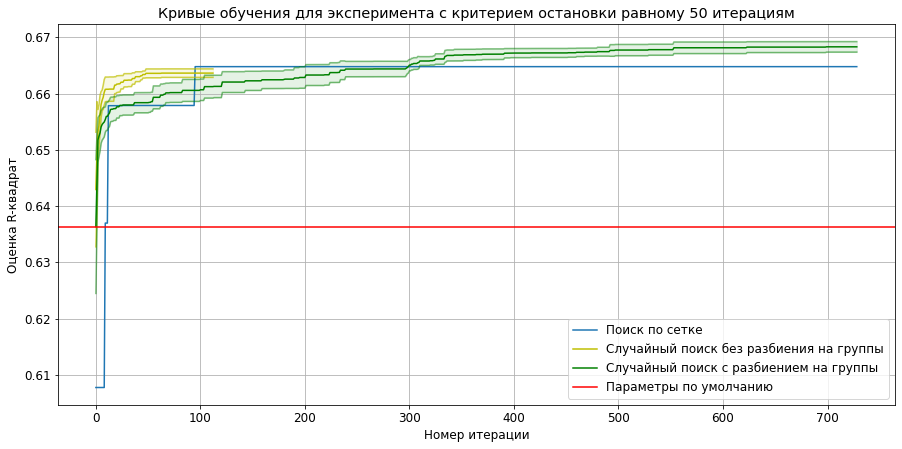

In [35]:
# Data with stop criterion
# stop if the cumulative score hasn't grown in "stop_iter_num" iterations
# GRID_SEARCH
#get best scores per itration for grid_search performance:
grid_perf=grid_df.loc[grid_df['experiment_name']!='default params',
                      'mean_test_score'].cummax()


## RANDOM_SEARCH
# get best scores per itration for each random_search performance:
# random_df_stopped
    
#get mean and confidence interval value for random_search performance on iteration:    

z = 1.96 # for 95% conf interval (coefficient)
# z = 1.64 # for 90% conf interval

n=10
random_std=random_df_stopped.groupby(by="iter_num")['mean_test_score'].std() #std
random_std=(random_std*z)/np.sqrt(n) #confidence interval value 
random_mean=random_df_stopped.groupby(by="iter_num")['mean_test_score'].mean() #mean


## GROUP_SEARCH
#get best scores per itration for each group_search performance (same computations):

n=10
group_std=full_df.groupby(by="iter_num")['mean_test_score'].std()
group_std=(group_std*z)/np.sqrt(n) 
group_std=group_std.fillna(0)
group_mean=full_df.groupby(by="iter_num")['mean_test_score'].mean()

## DEFAULT performance
default_perf=default_df.loc[:,'mean_test_score'].values[0]


## PLOT
plt.figure(figsize=(15,7))
plt.grid()

#grid plot:
x=list(range(0, grid_perf.shape[0]))
plt.plot(x, grid_perf, label="Поиск по сетке")

#conf for random:
x=list(range(0, random_mean.shape[0]))
plt.plot(x, random_mean, color="y", label="Случайный поиск без разбиения на группы")
lower_random=random_mean - random_std
upper_random=random_mean + random_std
plt.plot(x, lower_random, alpha=0.7, color="y")
plt.plot(x, upper_random, alpha=0.7, color="y")
plt.fill_between(x, lower_random, upper_random, alpha=0.1, color="y") 

#conf for group:
x=list(range(0, group_mean.shape[0]))
plt.plot(x, group_mean, color="green", label="Случайный поиск с разбиением на группы")
lower_group=group_mean - group_std
upper_group=group_mean + group_std
plt.plot(x, lower_group, alpha=0.5, color="green")
plt.plot(x, upper_group, alpha=0.5, color="green")
plt.fill_between(x, lower_group, upper_group, alpha=0.1, color="green")

#line for default values
plt.axhline(default_perf, label="Параметры по умолчанию", color='r')
plt.axvline(243, label="Границы групп", color='k', ls = "--")
plt.axvline(243*2, color='k', ls = "--")

plt.legend()
plt.title("Кривые обучения для эксперимента с критерием остановки равному {} итерациям".format(stop_iter_num))
plt.ylabel("Оценка R-квадрат")
plt.xlabel("Номер итерации")
plt.savefig(GRAPHS_DIR+"scores_with_stop_{} {}.jpg".format(stop_iter_num, 
                                                                   dataset_name))
plt.show()

In [36]:
agg_df_GRS = full_df.groupby('run_number')['mean_test_score'].max().values
agg_df_RS = random_df_stopped.groupby('run_number')['mean_test_score'].max().values

In [37]:
scores_info['GRS_{}'.format(stop_iter_num)] = {
    'mean':np.mean(agg_df_GRS), 
    'std':np.nanstd(agg_df_GRS)
}
scores_info['RS_{}'.format(stop_iter_num)] = {
    'mean':np.mean(agg_df_RS), 
    'std':np.nanstd(agg_df_RS)
}

In [100]:
scores_info

{'GRS_25': {'mean': 0.6688258864812872, 'std': 0.0013847701883868068},
 'RS_25': {'mean': 0.6629300025891549, 'std': 0.0014621534623719566},
 'GRS_50': {'mean': 0.6683239034530961, 'std': 0.0014285767131122214},
 'RS_50': {'mean': 0.6636493329516642, 'std': 0.0011570015726666528},
 'GRS_10': {'mean': 0.6683499488506008, 'std': 0.0012250001012563663},
 'RS_10': {'mean': 0.6617711189273625, 'std': 0.002578278215751294}}

In [101]:
iters_info

{'GRS_25': {'mean': 517.0, 'std': 118.66254674496076},
 'RS_25': {'mean': 42.7, 'std': 19.02656038279121},
 'GRS_50': {'mean': 547.9, 'std': 103.30000000000001},
 'RS_50': {'mean': 77.5, 'std': 23.165707414193076},
 'GRS_10': {'mean': 521.8, 'std': 124.07239821974909},
 'RS_10': {'mean': 18.4, 'std': 7.323933369440222}}

In [102]:
with open(second_test_path + "scores_info.txt", 'w') as outfile:
    json.dump(scores_info, outfile)
    

with open(second_test_path + "iters_info.txt", 'w') as outfile:
    json.dump(iters_info, outfile)

